In [1]:
import pandas as pd
df=pd.read_csv('train_indessa.csv')

In [2]:
df.drop(['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','desc',
         'verification_status_joint','batch_enrolled','sub_grade','title','zip_code','addr_state',
        'emp_title'],axis=1,inplace=True)

In [3]:
df['emp_length'].replace('n/a', '0', inplace=True)
df['emp_length'].replace(to_replace='\+ years', value='', regex=True, inplace=True)
df['emp_length'].replace(to_replace=' years', value='', regex=True, inplace=True)
df['emp_length'].replace(to_replace='< 1 year', value='0', regex=True, inplace=True)
df['emp_length'].replace(to_replace=' year', value='', regex=True, inplace=True)

df['emp_length'].fillna(df.emp_length.median(),inplace=True)

df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')

In [4]:
df['last_week_pay'] = df['last_week_pay'].str.extract('(\d+)', expand=False)
df['last_week_pay'].fillna(df['last_week_pay'].median(), inplace=True)
df['last_week_pay'] = pd.to_numeric(df['last_week_pay'], errors='coerce')

In [5]:
cols = ['loan_amnt', 'funded_amnt', 'int_rate',  'annual_inc', 'dti',  'open_acc', 'revol_bal', 'revol_util', 'total_acc',
        'total_rec_int','tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
for col in cols:
    print('Imputation with Median: %s' % (col))
    df[col].fillna(df[col].median(), inplace=True)

Imputation with Median: loan_amnt
Imputation with Median: funded_amnt
Imputation with Median: int_rate
Imputation with Median: annual_inc
Imputation with Median: dti
Imputation with Median: open_acc
Imputation with Median: revol_bal
Imputation with Median: revol_util
Imputation with Median: total_acc
Imputation with Median: total_rec_int
Imputation with Median: tot_coll_amt
Imputation with Median: tot_cur_bal
Imputation with Median: total_rev_hi_lim


In [6]:
cols = ['acc_now_delinq', 'collections_12_mths_ex_med',
       'delinq_2yrs','inq_last_6mths','pub_rec']
for col in cols:
    print('Imputation with Zero: %s' % (col))
    df[col].fillna(0, inplace=True)

Imputation with Zero: acc_now_delinq
Imputation with Zero: collections_12_mths_ex_med
Imputation with Zero: delinq_2yrs
Imputation with Zero: inq_last_6mths
Imputation with Zero: pub_rec


In [7]:
df['term'].replace(to_replace=' months', value='', regex=True, inplace=True)
df['term'] = pd.to_numeric(df['term'], errors='coerce')

In [8]:
import numpy as np
# Encode Label for Classifier
from sklearn.preprocessing import LabelEncoder
le1 = {}
le=['home_ownership','application_type','initial_list_status','pymnt_plan','purpose','initial_list_status','grade','verification_status']

for col in le:
    le1[col] = LabelEncoder()
    df[col] = le1[col].fit_transform(df[col])
    le1[col].classes_ = np.append(le1[col].classes_, 'other')
    
    print('Encoded: ', col)

Encoded:  home_ownership
Encoded:  application_type
Encoded:  initial_list_status
Encoded:  pymnt_plan
Encoded:  purpose
Encoded:  initial_list_status
Encoded:  grade
Encoded:  verification_status


In [9]:
# Interest paid so far
df['int_paid'] = df['total_rec_int'] + df['total_rec_late_fee']

# Total number of available/unused 'credit lines'
df['avl_lines'] = df['total_acc'] - df['open_acc']

df['sanctinoned'] = (df['funded_amnt'] + df['funded_amnt_inv']).div(2)

df['total_repayment_progress'] = ((df['last_week_pay']/(df['term']/12*52+1))*100) + ((df['recoveries']/df['funded_amnt_inv']) * 100)

df.insert(0, 'payment_completion', (df['last_week_pay']/(df['term']/12*52+1))*100)

df['loan_to_income'] = df['annual_inc']/df['funded_amnt_inv']


In [10]:
df.replace([np.inf, -np.inf], 0, inplace=True)

In [11]:
df.isnull().sum()

payment_completion              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
grade                           0
emp_length                      0
home_ownership                  0
annual_inc                      0
verification_status             0
pymnt_plan                      0
purpose                         0
dti                             0
delinq_2yrs                     0
inq_last_6mths                  0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                      0
total_acc                       0
initial_list_status             0
total_rec_int                   0
total_rec_late_fee              0
recoveries                      0
collection_recovery_fee         0
collections_12_mths_ex_med      0
application_type                0
last_week_pay 

In [12]:
df.fillna(0,inplace=True)

In [13]:
df.isnull().sum()

payment_completion            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
pymnt_plan                    0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
collections_12_mths_ex_med    0
application_type              0
last_week_pay                 0
acc_now_delinq                0
tot_coll

In [14]:
from sklearn.model_selection import train_test_split
X=df.drop(['loan_status','member_id'],axis=1)
y=df[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.30,random_state =123)

In [15]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [17]:
rf = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5, verbose=5, n_jobs=-1)
rf.fit(X_train_norm, y_train)

preds = rf.predict(X_test_norm)
fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], preds)
auc1 = roc_auc_score(y_test['loan_status'], preds)

print(auc1)
rf.score(X_test_norm, y_test)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 180building tree 2 of 180

building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.1s


building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min


building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82 of 180
building tree 83 of 180
building tree 84 of 180
building tree 85 of 180
building tree 86 of 180
building tree 87 of 180
building tree 88 of 180
building tree 89 of 180
building tree 90 of 180
building tree 91 of 180
building tree 92 of 180
building tree 93 of 180
building tree 94 of 180
building tree 95 of 180
building tree 96 of 180
building tree 97 of 180
building tree 98 of 180
building tree 99 of 180
building tree 100 of 180
building tree 101 of 180
building tree 102 of 180
building tree 103 of 180
building tree 104 of 180
building tree 105 of 180
building tree 106 of 180
building tree 107 of 180
building tree 108 of 180
buildin

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.1min


building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


0.7422972492660298


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    4.9s finished


0.8710002566847598

In [18]:
fi = list(zip(X_train.columns.values, rf.feature_importances_))
fi = sorted(fi, key=lambda x: -x[1])
qw=pd.DataFrame(fi, columns=["Feature","Importance"])

In [19]:
feat=qw['Feature'].tolist()

In [20]:
df1=df[feat[:20]]
X=df1
y=df[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.30,random_state =123)

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_norm, y_train)
gbc_score = gbc.score(X_test_norm, y_test)
gbc_score

/home/ds/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8350205660838045

In [25]:
preds = gbc.predict(X_test_norm)
fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], preds)
auc1 = roc_auc_score(y_test['loan_status'], preds)
print(auc1)

0.6574999094028949


In [22]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(random_seed = 31)
cbc.fit(X_train_norm, y_train, verbose=False)
cbc_score = cbc.score(X_test_norm, y_test)
cbc_score

0.9088831708706622

In [24]:
preds = cbc.predict(X_test_norm)
fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], preds)
auc1 = roc_auc_score(y_test['loan_status'], preds)
print(auc1)

0.8325020779558315


In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

cbc_grid = {'iterations':[10, 100, 200, 500, 1000],
            'learning_rate': [0.1, 0.01]}


cbc_clf = GridSearchCV(CatBoostClassifier(random_state = 31),
                      param_grid = cbc_grid,
                           cv=5,
                           verbose=True)

cbc_clf.fit(X_train_norm, y_train, verbose=False)
cbc_tuned_score = cbc_clf.score(X_test_norm, y_test)
cbc_tuned_score
preds = cbc_clf.predict(X_test_norm)
fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], preds)
auc1 = roc_auc_score(y_test['loan_status'], preds)
print(auc1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 41.8min finished


NameError: name 'cbc_clf1' is not defined

In [28]:
preds = cbc_clf.predict(X_test_norm)
fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], preds)
auc1 = roc_auc_score(y_test['loan_status'], preds)
print(auc1)

0.8268315923648579


In [29]:
!pip install fastai2

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 179 kB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 17.4 MB 30.3 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 804.1 MB 3.3 kB/s  eta 0:00:01    |███▏                            | 78.9 MB 48.6 MB/s eta 0:00:15     |█████                           | 126.5 MB 51.7 MB/s eta 0:00:14     |█████▋                          | 140.9 MB 51.7 MB/s eta 0:00:13     |█████████                       | 227.0 MB 50.7 MB/s eta 0:00:12     |█████████▊                      | 244.9 MB 47.2 MB/s eta 0:00:12     |███████████▋                    | 290.5 MB 47.2 MB/s eta 0:00:11     |███████████████                 | 377.6 MB 42.6 MB/s eta 0:00:11     |███████████████▏                | 382.4 MB 41.0 MB/s eta 0:00:11     |███████████████▉                | 396.9 MB 41.0 MB/s eta 0:00:10     |███████████

In [30]:
!pip install fastcore==0.1.35

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.3.20
    Uninstalling fastcore-1.3.20:
      Successfully uninstalled fastcore-1.3.20
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [31]:
import fastcore
fastcore.__version__

'0.1.35'

In [32]:
import fastai2
fastai2.__version__

'0.0.30'

In [33]:
from fastai2.tabular.all import *

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

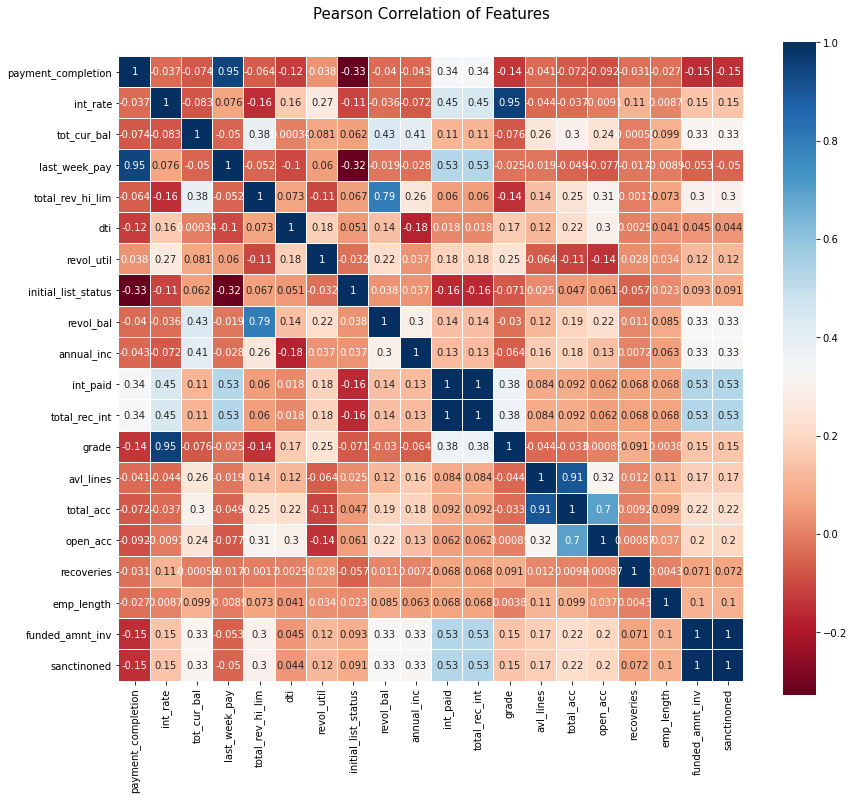

In [35]:
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df1.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [36]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train_norm, y_train)
xgb_predictions = gbm.predict(X_test_norm)

/home/ds/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [37]:
#preds = cbc_clf.predict(X_test_norm)
fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], xgb_predictions)
auc1 = roc_auc_score(y_test['loan_status'], xgb_predictions)
print(auc1)

0.840256523714579


In [38]:
df.shape

(532428, 40)

In [40]:
for i in range(10,40,10):
    print(i)
    df1=df[feat[:i]]
    X=df1
    y=df[['loan_status']]
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.30,random_state =123)

    # fit scaler on training data
    norm = MinMaxScaler().fit(X_train)

    # transform training data
    X_train_norm = norm.transform(X_train)

    # transform testing dataabs
    X_test_norm = norm.transform(X_test)
    gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread= -1,
     scale_pos_weight=1).fit(X_train_norm, y_train)
    xgb_predictions = gbm.predict(X_test_norm)
    #preds = cbc_clf.predict(X_test_norm)
    fpr1, tpr1, thr1 = roc_curve(y_test['loan_status'], xgb_predictions)
    auc1 = roc_auc_score(y_test['loan_status'], xgb_predictions)
    print(auc1)

10


/home/ds/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7919099227861975
20


/home/ds/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.840256523714579
30


/home/ds/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8403549149017089


In [41]:
feat[:20]

['payment_completion',
 'int_rate',
 'tot_cur_bal',
 'last_week_pay',
 'total_rev_hi_lim',
 'dti',
 'revol_util',
 'initial_list_status',
 'revol_bal',
 'annual_inc',
 'int_paid',
 'total_rec_int',
 'grade',
 'avl_lines',
 'total_acc',
 'open_acc',
 'recoveries',
 'emp_length',
 'funded_amnt_inv',
 'sanctinoned']

In [42]:
feat

['payment_completion',
 'int_rate',
 'tot_cur_bal',
 'last_week_pay',
 'total_rev_hi_lim',
 'dti',
 'revol_util',
 'initial_list_status',
 'revol_bal',
 'annual_inc',
 'int_paid',
 'total_rec_int',
 'grade',
 'avl_lines',
 'total_acc',
 'open_acc',
 'recoveries',
 'emp_length',
 'funded_amnt_inv',
 'sanctinoned',
 'loan_amnt',
 'funded_amnt',
 'verification_status',
 'inq_last_6mths',
 'term',
 'purpose',
 'collection_recovery_fee',
 'tot_coll_amt',
 'home_ownership',
 'delinq_2yrs',
 'pub_rec',
 'total_rec_late_fee',
 'collections_12_mths_ex_med',
 'loan_to_income',
 'acc_now_delinq',
 'pymnt_plan',
 'total_repayment_progress',
 'application_type']